In [13]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2


In [39]:
wavelength = [404,435,505,546,578]
p_uw_calibration = np.array([1.8,1.9,2.2,3,3.1])
p_uw_calibration=p_uw_calibration/max(p_uw_calibration)


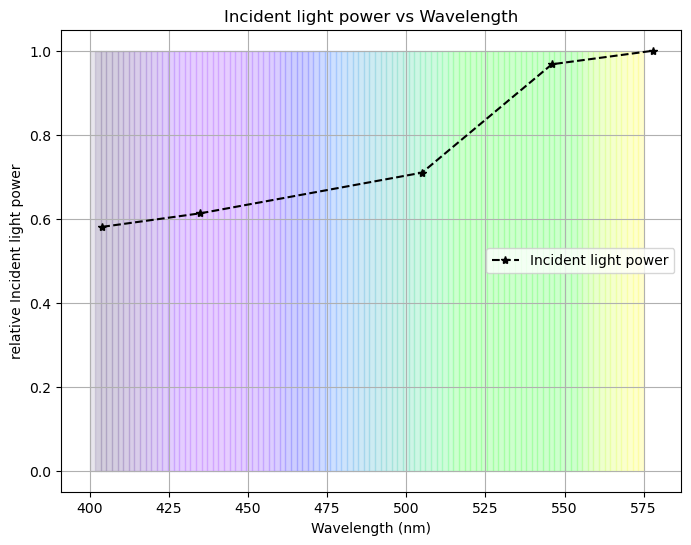

In [44]:

plt.style.use('default')
plt.figure(figsize=(8, 6))

plt_spec()
plt.plot(wavelength,p_uw_calibration,"--*k", label="Incident light power")
plt.xlabel("Wavelength (nm)")
plt.ylabel("relative Incident light power")
plt.title("Incident light power vs Wavelength")
plt.grid(True)
plt.legend()
plt.show()


In [12]:
import os
import glob
import re

# Base directory containing the folders
base_directory = 'CMOS_Img/CapObj/'

# List to store details of each image file
image_data = []

# Regex pattern to match folders like "1500us_404nm_200" and extract components
pattern = r"(\d+)us_(\d+)nm_(\d+)"

# Traverse through each folder in the base directory
for folder in os.listdir(base_directory):
    folder_path = os.path.join(base_directory, folder)
    
    # Only process folders matching the pattern and containing PNG files
    if os.path.isdir(folder_path) and re.match(pattern, folder):
        # Extract exposure, wavelength, and gain from the folder name
        match = re.match(pattern, folder)
        exposure = int(match.group(1))    # in microseconds
        wavelength = int(match.group(2))  # in nm
        gain = int(match.group(3))        # gain
        
        # List all PNG files in the current folder
        png_files = glob.glob(f"{folder_path}/*.PNG")
        
        # Append each file with its metadata to the image_data list
        for file_path in png_files:
            if gain != 200:
                continue
            image_data.append({
                "file_path": file_path,
                "exposure": exposure,
                "wavelength": wavelength,
                "gain": gain
            })

# Display the structured list of image data
for data in image_data:
    print(data)


{'file_path': 'CMOS_Img/CapObj/550us_546nm_200/2024-10-25-0615_7-CapObj_0000.PNG', 'exposure': 550, 'wavelength': 546, 'gain': 200}
{'file_path': 'CMOS_Img/CapObj/900us_505nm_200/2024-10-25-0614_8-CapObj_0000.PNG', 'exposure': 900, 'wavelength': 505, 'gain': 200}
{'file_path': 'CMOS_Img/CapObj/450us_578nm_200/2024-10-25-0611_7-CapObj_0000.PNG', 'exposure': 450, 'wavelength': 578, 'gain': 200}
{'file_path': 'CMOS_Img/CapObj/1800us_435nm_200/2024-10-25-0613_8-CapObj_0000.PNG', 'exposure': 1800, 'wavelength': 435, 'gain': 200}
{'file_path': 'CMOS_Img/CapObj/2500us_404nm_200/2024-10-25-0612_8-CapObj_0000.PNG', 'exposure': 2500, 'wavelength': 404, 'gain': 200}


In [14]:


# Function to calculate total intensity after background subtraction
def calculate_total_intensity(image, background_image):
    # Resize the background image if needed
    if background_image.shape != image.shape:
        resized_background = cv2.resize(background_image, (image.shape[1], image.shape[0]))
    else:
        resized_background = background_image
    
    # Subtract the background from the image
    subtracted_image = cv2.subtract(image, resized_background)
    
    # Calculate the total intensity (sum of all pixel values)
    total_intensity = np.sum(subtracted_image)
    
    return total_intensity


In [15]:

# Path to the background image
background_path = './CMOS_Img/32us_cap_off/2024-10-25-0551_4-CapObj_0000.PNG'
background_image = cv2.imread(background_path, cv2.IMREAD_GRAYSCALE)

In [16]:


# Ensure background_image is loaded
if background_image is None:
    print("Error: Background image not found.")
    exit()

# Dictionary to store total intensity values at different wavelengths
intensity_data = {}

# Process each image in the list `image_data`
for data in image_data:
    # Load each image
    image_path = data["file_path"]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Ensure image is loaded
    if image is None:
        print(f"Error: Could not load image {image_path}. Skipping...")
        continue

    # Calculate total intensity after background subtraction
    total_intensity = calculate_total_intensity(image, background_image)
    
    # Store intensity data with wavelength and exposure time
    wavelength = data["wavelength"]
    exposure = data["exposure"]
    intensity_data[(wavelength, exposure)] = total_intensity

# Display intensity data for comparison
print("Total Intensity at Different Wavelengths:")
for (wavelength, exposure), intensity in intensity_data.items():
    print(f"Wavelength: {wavelength} nm, Exposure: {exposure} us, Total Intensity: {intensity}")


Total Intensity at Different Wavelengths:
Wavelength: 546 nm, Exposure: 550 us, Total Intensity: 378069166
Wavelength: 505 nm, Exposure: 900 us, Total Intensity: 369046778
Wavelength: 578 nm, Exposure: 450 us, Total Intensity: 370675376
Wavelength: 435 nm, Exposure: 1800 us, Total Intensity: 385527866
Wavelength: 404 nm, Exposure: 2500 us, Total Intensity: 341013426


In [49]:


# Define the reference exposure time (e.g., 1000 microseconds)
reference_exposure = 32

# Define power input calibration values for specific wavelengths
wavelength_to_power = {
    404: 1.8,
    435: 1.9,
    505: 2.2,
    546: 3.0,
    578: 3.1
}

# Function to calculate scaled and normalized intensity
def calculate_normalized_intensity(image, background_image, exposure, wavelength):
    # Resize the background image if needed
    if background_image.shape != image.shape:
        resized_background = cv2.resize(background_image, (image.shape[1], image.shape[0]))
    else:
        resized_background = background_image
    
    # Subtract the background from the image
    subtracted_image = cv2.subtract(image, resized_background)
    
    # Calculate the total intensity (sum of all pixel values)
    total_intensity = np.sum(subtracted_image)
    
    # Scale intensity to the reference exposure time
    scaled_intensity = total_intensity * (reference_exposure / exposure)
    
    # Normalize by the input power for the specific wavelength
    normalized_intensity = scaled_intensity / wavelength_to_power.get(wavelength, 1)
    
    return normalized_intensity

# Ensure background_image is loaded
if background_image is None:
    print("Error: Background image not found.")
    exit()

# Dictionary to store normalized intensity values at different wavelengths
intensity_data = {}

# Process each image in the list `image_data`
for data in image_data:
    # Load each image
    image_path = data["file_path"]
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Ensure image is loaded
    if image is None:
        print(f"Error: Could not load image {image_path}. Skipping...")
        continue

    # Extract exposure and wavelength
    exposure = data["exposure"]
    wavelength = data["wavelength"]
    
    # Calculate normalized intensity
    normalized_intensity = calculate_normalized_intensity(image, background_image, exposure, wavelength)
    
    # Store normalized intensity data
    intensity_data[(wavelength, exposure)] = normalized_intensity

# Display normalized intensity data for comparison
print("Normalized Intensity at Different Wavelengths (Scaled to Reference Exposure):")
for (wavelength, exposure), intensity in intensity_data.items():
    print(f"Wavelength: {wavelength} nm, Exposure: {exposure} us, Normalized Intensity: {intensity:.2f}")


Normalized Intensity at Different Wavelengths (Scaled to Reference Exposure):
Wavelength: 546 nm, Exposure: 550 us, Normalized Intensity: 7332250.49
Wavelength: 505 nm, Exposure: 900 us, Normalized Intensity: 5964392.37
Wavelength: 578 nm, Exposure: 450 us, Normalized Intensity: 8502947.69
Wavelength: 435 nm, Exposure: 1800 us, Normalized Intensity: 3607278.28
Wavelength: 404 nm, Exposure: 2500 us, Normalized Intensity: 2424984.36


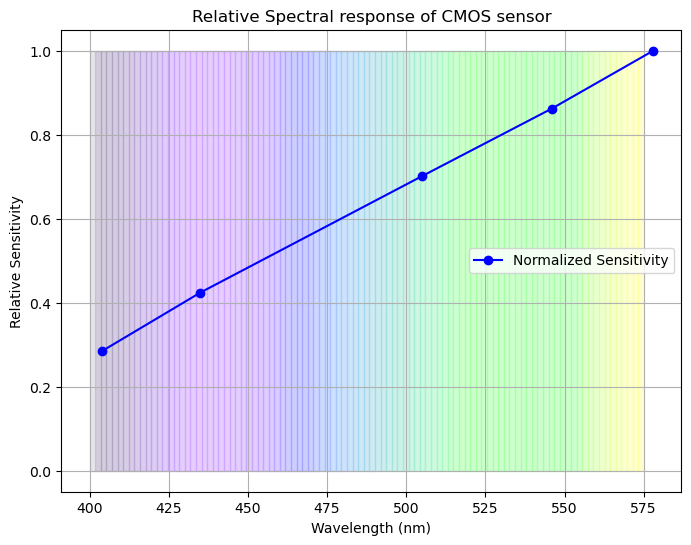

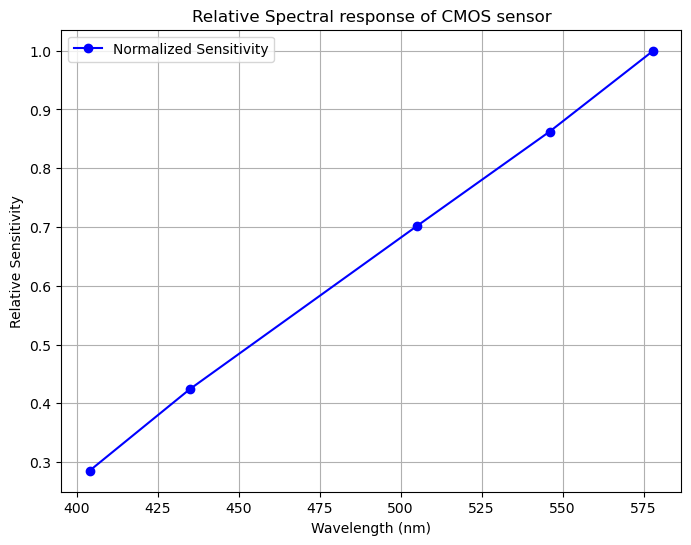

In [51]:

# Prepare data for plotting
wavelengths = []
normalized_intensities = []

# Extract data from intensity_data dictionary
for (wavelength, exposure), intensity in intensity_data.items():
    wavelengths.append(wavelength)
    normalized_intensities.append(intensity)

normalized_intensities = normalized_intensities/max(normalized_intensities)
# Sort data by wavelength for a smoother plot
sorted_data = sorted(zip(wavelengths, normalized_intensities))
wavelengths, normalized_intensities = zip(*sorted_data)

# Plotting
plt.figure(figsize=(8, 6))
plt_spec()
plt.plot(wavelengths, normalized_intensities, marker='o', linestyle='-', color='b', label='Normalized Sensitivity')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Sensitivity")
plt.title("Relative Spectral response of CMOS sensor")
plt.grid(True)
plt.legend()
plt.show()

plt.style.use('default')
plt.figure(figsize=(8, 6))

plt.plot(wavelengths, normalized_intensities, marker='o', linestyle='-', color='b', label='Normalized Sensitivity')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Sensitivity")
plt.title("Relative Spectral response of CMOS sensor")
plt.grid(True)
plt.legend()
plt.show()


In [34]:
import colour
import matplotlib.colors as mcolors

def wavelength_to_hex(wavelength):
    # Convert wavelength to XYZ color space
    xyz = colour.wavelength_to_XYZ(wavelength)
    
    # Convert XYZ to RGB
    rgb = colour.XYZ_to_sRGB(xyz)
    
    # Ensure RGB values are within bounds (0, 1) and then scale to (0, 255)
    rgb = [max(0, min(1, c)) for c in rgb]
    rgb = [int(c * 255) for c in rgb]
    
    # Convert to hex
    hex_color = mcolors.to_hex([x / 255.0 for x in rgb])
    
    return hex_color

# Example: Convert 500 nm (greenish) to hex
wavelength = 500  # Wavelength in nanometers
hex_color = wavelength_to_hex(wavelength)
print(f"Wavelength {wavelength} nm corresponds to hex color {hex_color}")


plt.style.use('dark_background')
def plt_spec():    
    # Wavelength range for the plot
    x = np.linspace(400, 575, 100)  # Generate wavelength values from 400 to 1000 nm
    y = 1  # Example function to plot
    
    # Create a plot
    #fig, ax = plt.subplots(figsize=(10, 7))
    
    # Loop over each color range and create a rectangle with the corresponding color
    for i in range(len(x)-1):
        color = wavelength_to_hex(x[i])
        a = x[i]+1
        plt.fill_between(x, y, where=(x >= x[i]) & (x <= x[i]+5), color=color, alpha=0.1)
    
    color_ranges = {
        'IRed': (700, 800),
        'IRed2': (800, 940)
    }
    
    # Define the corresponding colors
    color_map = {
        'IRed': '#440000',
        'IRed2': '#220000'
    }
    # Wavelength range for the plot
    x = np.linspace(400,575, 1000)  # Generate wavelength values from 400 to 1000 nm
    y = 1  # Example function to plot
    
    
    # Loop over each color range and create a rectangle with the corresponding color
    for color, (start_wl, end_wl) in color_ranges.items():
        plt.fill_between(x, y, where=(x >= start_wl) & (x <= end_wl), color=color_map[color], alpha=0.2)#, label=f"{start}-{end} nm")

    plt.figsize=(10, 7)

Wavelength 500 nm corresponds to hex color #00cd81
